In [4]:
from collections import defaultdict
from dataclasses import replace
from dnadb import dna, fasta, sample, taxonomy
from graphviz import Digraph
from lmdbm import Lmdb
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
from pathlib import Path
import pickle
import re
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_curve, precision_recall_fscore_support
import sys
import tensorflow as tf
import tf_utilities as tfu
from tqdm.auto import tqdm
from typing import Iterable, Optional
import wandb

In [5]:
sys.path.append("../src")
from deepdna.nn.data_generators import SampleGenerator, _encode_sequences
from deepdna.nn.metrics import f1_score, positive_predictive_value, negative_predictive_value
from deepdna.nn.models import load_model, setbert

In [6]:
# tfu.devices.select_cpu()
tfu.devices.select_gpu(1)

2023-07-12 07:04:38.503782: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-12 07:04:38.504018: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-12 07:04:38.650655: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-12 07:04:38.650996: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-12 07:04:38.651275: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

([PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')],
 [PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')])

In [7]:
output_path = Path("/home/dwl2x/work/Datasets/Walker_Alex")
output_path.mkdir(exist_ok=True)

In [8]:
fasta_path = Path("/home/shared/walker_lab/alex/P_A_221205_cmfp.trim.contigs.pcr.good.unique.good.filter.unique.precluster.denovo.vsearch.pick.opti_mcc.0.03.pick.0.03.abund.0.03.pick.fasta")
otu_list_path = Path("/home/shared/walker_lab/digitalocean/Alex_SFD/shared_list/221205_cmfp.trim.contigs.pcr.good.unique.good.filter.unique.precluster.denovo.vsearch.asv.list")
otu_shared_path = Path("/home/shared/walker_lab/digitalocean/Alex_SFD/shared_list/221205_cmfp.trim.contigs.pcr.good.unique.good.filter.unique.precluster.denovo.vsearch.asv.shared")
metadata_path = Path("/home/shared/walker_lab/alex/230320_sfdspatial_meta_clean.csv")

## FASTA DB

In [9]:
def clean_entry(entry: fasta.FastaEntry):
    sequence = re.sub(r"[^" + dna.ALL_BASES + r"]", "", entry.sequence)
    return replace(entry, sequence=sequence)

In [10]:
# factory = fasta.FastaDbFactory(output_path / "alex.fasta.db")
# for entry in tqdm(map(clean_entry, fasta.entries(fasta_path))):
#     if len(entry) < 250:
#         continue
#     factory.write_entry(entry)
# factory.close()

In [11]:
fasta_db = fasta.FastaDb(output_path / "alex.fasta.db")

---

## Sample OTU Index

In [12]:
# with open(otu_list_path) as f:
#     keys = f.readline().strip().split('\t')
#     values = f.readline().strip().split('\t')
# otu_index = dict(zip(keys[2:], values[2:]))

In [13]:
# list(otu_index.values())[:5]

In [14]:
# factory = fasta.FastaIndexDbFactory(output_path / "alex.fasta.index.db")
# for i, asv in enumerate(tqdm(otu_index)):
#     fasta_id = otu_index[asv]
#     if fasta_id not in fasta_db:
#         continue
#     factory.write_entry(fasta_db[fasta_id], key=asv)
# factory.close()

In [15]:
index_db = fasta.FastaIndexDb(output_path / "alex.fasta.index.db")

---

## Load Metadata

In [16]:
metadata = pd.read_csv(metadata_path, index_col=0)
metadata

,taxon,ecomode,oo_present,date,county,site,clinical_signs,log_copy_number,gpsn,gpsw,...,swab_col,DNA_con,swab_plate_n,notes,richness,shannon,evenness,simpson,invsimpson,dis.sev
swab_label,,,,,,,,,,,,,,,,,,,,,
STP582C,Agkistrodon piscivorus,Aquatic,0,6/7/2015,Polk,Ouachita National Forest,NaN,0.00000,34.46294,-93.99638,...,1.0,3.06,1.0,Walker et al. ISME,618,4.804865,0.197578,0.974111,38.627160,Neg
STP633C,Crotalus horridus,Terrestrial,0,6/8/2015,Polk,Ouachita National Forest,NaN,0.00000,34.46262,-93.99853,...,1.0,2.18,1.0,Walker et al. ISME,486,4.505452,0.186233,0.962531,26.688501,Neg
STP634C,Agkistrodon piscivorus,Aquatic,0,6/8/2015,Polk,Ouachita National Forest,NaN,0.00000,34.57593,-94.03164,...,1.0,40.80,1.0,Walker et al. ISME,456,2.743417,0.034079,0.723965,3.622725,Neg
STP639C,Agkistrodon piscivorus,Aquatic,0,6/8/2015,Montgomery,Ouachita National Forest,NaN,0.00000,34.43632,-93.78750,...,1.0,3.90,1.0,Walker et al. ISME,659,4.919205,0.207730,0.975840,41.391414,Neg
STP640C,Agkistrodon piscivorus,Aquatic,0,6/8/2015,Montgomery,Ouachita National Forest,NaN,0.00000,34.43632,-93.78750,...,1.0,6.14,1.0,Walker et al. ISME,384,4.312839,0.194407,0.963434,27.347450,Neg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
STP1502C,Nerodia sipedon,Aquatic,1,NaN,Overton,Waterloo Falls,NaN,0.30103,NaN,NaN,...,11.0,22.60,2.0,Walker et al. ISME,692,4.422581,0.120392,0.959926,24.954109,Low
STP1503C,Nerodia sipedon,Aquatic,1,NaN,Overton,Waterloo Falls,NaN,0.30103,NaN,NaN,...,11.0,22.60,2.0,Walker et al. ISME,823,5.162691,0.212192,0.980217,50.549217,Low
STP762C,Thamnophis sirtalis,Terrestrial,1,NaN,Cumberland,Catoosa WMA,NaN,1.00000,NaN,NaN,...,2.0,23.20,1.0,Walker et al. ISME - Austin Property-Crossville,739,4.925323,0.186379,0.979888,49.721213,Low


In [17]:
# metadata_sample_names = set(metadata.index.to_list())

---

## Sample Mapping

In [18]:
# with open(otu_shared_path) as f:
#     header = f.readline().strip().split('\t')
#     lines = [line.strip().split('\t') for line in tqdm(f)]
# len(lines)

In [19]:
# cols = [i for i in range(3, len(header)) if index_db.contains_key(header[i])]

In [20]:
# header[:5]

In [21]:
# index_db.key_to_fasta_id("ASV0000004")

In [22]:
# indices = [i for i in tqdm(range(3, len(header))) if index_db.contains_key(header[i])]

In [23]:
# fasta_ids = {i: index_db.key_to_fasta_id(header[i]) for i in tqdm(indices)}

In [24]:
# factory = sample.SampleMappingDbFactory(output_path / "alex.fasta.mapping.db")
# for row in tqdm(lines):
#     sample_name = row[1]
#     if sample_name not in metadata_sample_names:
#         continue
#     sample_factory = sample.SampleMappingEntryFactory(sample_name, index_db)
#     for i in indices:
#         if (count := int(row[i])) == 0:
#             continue
#         fasta_id = fasta_ids[i]
#         sample_factory.add_entry(fasta_db[fasta_id], count)
#     factory.write_entry(sample_factory.build())
# factory.close()

In [25]:
mapping = sample.SampleMappingDb(output_path / "alex.fasta.mapping.db", index_db)

In [26]:
sample_names = set([sample.name for sample in mapping])
len(sample_names)

737

## Taxonomy

In [27]:
tax_data = pd.read_csv("/home/shared/walker_lab/alex/230428_SFDtaxfinal_engineer.csv")
tax_data

,otu,kingdom,phylum,class,order,family,genus
0,Otu000002,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Intrasporangiaceae,Janibacter
1,Otu000003,Bacteria,Deinococcus-Thermus,Deinococci,Deinococcales,Deinococcaceae,Deinococcus
2,Otu000004,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,Burkholderiaceae_unclassified
3,Otu000005,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Moraxellaceae,Acinetobacter
4,Otu000006,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,Burkholderiaceae_unclassified
...,...,...,...,...,...,...,...
25047,Otu069105,Bacteria,Proteobacteria,Gammaproteobacteria,Gammaproteobacteria_unclassified,Gammaproteobacteria_unclassified,Gammaproteobacteria_unclassified
25048,Otu069123,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Enterobacteriaceae_unclassified
25049,Otu069172,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Microbacteriaceae,Microbacteriaceae_unclassified
25050,Otu069191,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Betaproteobacteriales_unclassified,Betaproteobacteriales_unclassified


In [28]:
tax_dict = {}
for _, row in tax_data.iterrows():
    otu, taxons = row[0], taxonomy.join_taxonomy(tuple(row.values[1:]))
    tax_dict[otu] = taxons

In [29]:
tax_dict["Otu000002"]

'k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Micrococcales; f__Intrasporangiaceae; g__Janibacter'

In [30]:
asv_to_otu = {}
for entry in fasta_db:
    otu_id = entry.extra.split()[1]
    assert otu_id.startswith("Otu")
    asv_to_otu[entry.identifier] = otu_id
len(asv_to_otu)

1883435

---

## Pathogen Load TSVs

In [31]:
# with open(output_path / "alex.pathogen_load.tsv", "w") as f:
#     f.write(f"label\tpathogen_load\n")
#     for index, row in metadata.iterrows():
#         if index not in sample_names:
#             continue
#         f.write(f"{index}\t{row['log_copy_number']}\n")

---

## Data Generator

In [32]:
# p = pd.read_csv(output_path / "alex.pathogen_load.tsv", sep="\t", index_col=0)
# p

In [33]:
from typing import Generic, TypeVar

_T = TypeVar("_T")

class SampleTargetGenerator(SampleGenerator, Generic[_T]):
    def __init__(
        self,
        samples: Iterable[sample.SampleInterface],
        targets: dict[str, _T],
        sequence_length: int,
        kmer: int = 1,
        subsample_size: int|None = None,
        augment_slide: bool = True,
        augment_ambiguous_bases: bool = True,
        batch_size: int = 32,
        batches_per_epoch: int = 100,
        class_weights: Optional[npt.ArrayLike] = None,
        shuffle: bool = True,
        balance: bool = False,
        rng: np.random.Generator = np.random.default_rng()
    ):
        super().__init__(
            samples=samples,
            sequence_length=sequence_length,
            kmer=kmer,
            subsample_size=subsample_size,
            augment_slide=augment_slide,
            augment_ambiguous_bases=augment_ambiguous_bases,
            batch_size=batch_size,
            batches_per_epoch=batches_per_epoch,
            class_weights=class_weights,
            shuffle=shuffle,
            balance=balance,
            rng=rng
        )
        self.targets = targets

    def generate_batch(self, rng: np.random.Generator):
        subsample_size = self.subsample_size or 1
        sequence_ids = [None] * self.batch_size
        sequences = np.empty((self.batch_size, subsample_size), dtype=f"<U{self.sequence_length}")
        targets = []
        sample_names = []
        samples = self.sample_sampler.sample(self.batch_size, self.balance, rng)
        for i, sample in enumerate(samples):
            sample_names.append(sample.name)
            sequence_ids[i], sequences[i] = zip(*self.sequence_sampler.sample_with_ids(sample, subsample_size, rng))
            targets.append(self.targets[sample.name])
        sequences = _encode_sequences(sequences, self.augment_ambiguous_bases, self.rng)
        if self.subsample_size is None:
            sequences = np.squeeze(sequences, axis=1) # type: ignore
        if self.kmer > 1:
            sequences = dna.encode_kmers(sequences, self.kmer, not self.augment_ambiguous_bases)
        x, y = sequences.astype(np.int32), np.array(targets, dtype=np.float32)
        return sample_names, sequence_ids, x, y

    def reduce_batch(self, batch):
        return batch[2:]

## Construct Training/Validation Sets

In [34]:
rng = np.random.default_rng(0)

In [35]:
samples = [sample.DemultiplexedFastaSample(fasta_db, entry) for entry in mapping]

In [36]:
targets = pd.read_csv(output_path / "alex.pathogen_load.tsv", sep="\t", index_col=0)["pathogen_load"].astype(np.float32).to_dict()

In [37]:
rng.shuffle(samples)
# split_index = int(0.2*len(samples))
split_index = 0
train_samples = samples[split_index:]
# val_samples = samples[:split_index]
val_samples = train_samples

train_targets = {sample.name: targets[sample.name] for sample in train_samples}
val_targets = {sample.name: targets[sample.name] for sample in val_samples}
len(train_targets), len(val_targets)

(737, 737)

In [38]:
def compute_class_weights(samples, targets):
    negative_indices = np.array([1.0 if targets[sample.name] == 0.0 else 0.0 for sample in samples])
    positive_indices = 1 - negative_indices
    negative_weights = negative_indices / np.sum(negative_indices)
    positive_weights = positive_indices / np.sum(positive_indices)
    class_weights = positive_weights/2 + negative_weights/2
    return class_weights

In [39]:
# Test (should be ~= 500)
sum([train_targets[s.name] > 0.0 for s in rng.choice(train_samples, 1000, p=compute_class_weights(train_samples, train_targets))])

/tmp/ipykernel_4411/3560127358.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sum([train_targets[s.name] > 0.0 for s in rng.choice(train_samples, 1000, p=compute_class_weights(train_samples, train_targets))])


485

In [40]:
train_targets = {k: int(v > 0) for k, v in train_targets.items()}
val_targets = {k: int(v > 0) for k, v in val_targets.items()}

In [41]:
common_args = dict(
    sequence_length = 250,
    kmer = 3,
    subsample_size = 1000,
    batch_size=16
)

train_dataset = SampleTargetGenerator(
    train_samples,
    train_targets,
    class_weights=compute_class_weights(train_samples, train_targets),
    batches_per_epoch=20,
    **common_args
)

val_dataset = SampleTargetGenerator(
    val_samples,
    val_targets,
    class_weights=compute_class_weights(val_samples, val_targets),
    batches_per_epoch=16,
    shuffle=False,
    **common_args
)

In [42]:
train_dataset[0]

(array([[[49,  6, 27, ..., 16,  0,  1],
         [49,  4, 18, ..., 16,  0,  1],
         [ 6, 27, 44, ..., 32,  1,  4],
         ...,
         [26, 40, 34, ...,  1,  4, 18],
         [ 6, 27, 44, ...,  0,  1,  4],
         [49,  6, 27, ..., 16,  0,  1]],
 
        [[49,  6, 26, ..., 24, 32,  1],
         [40, 34, 10, ...,  5, 22, 26],
         [40, 34, 10, ...,  5, 22, 26],
         ...,
         [ 6, 27, 44, ..., 32,  1,  4],
         [40, 34, 10, ...,  4, 18, 10],
         [40, 34, 10, ...,  5, 22, 26]],
 
        [[26, 40, 34, ...,  1,  5, 22],
         [40, 34, 10, ...,  5, 22, 26],
         [49,  6, 26, ..., 24, 32,  1],
         ...,
         [26, 40, 34, ...,  1,  5, 22],
         [40, 34, 10, ...,  4, 18, 10],
         [49,  6, 27, ..., 24, 32,  1]],
 
        ...,
 
        [[49,  4, 18, ..., 16,  0,  1],
         [ 8, 34, 10, ...,  4, 18, 10],
         [ 4, 18,  8, ...,  0,  1,  4],
         ...,
         [44, 50, 10, ...,  4, 18, 10],
         [49,  6, 27, ..., 16,  0,  1],


## Loss Functions

In [43]:
def log_norm_dist_loss(y_true, y_pred):
    # Note that y_true is the original
    # regression target and y_pred will
    # be 2 values: mu and sigma (linear, softplus)
    epsilon = 1e-8 # can't compute log of 0
    l_mu, l_sigma = tf.unstack(y_pred, axis=-1)
    # l_mu = tf.expand_dims(l_mu,-1)
    # l_sigma = tf.expand_dims(l_sigma,-1)

    t1 = tf.math.log(l_sigma)
    t2 = tf.math.log(y_true + epsilon)
    t3 = tf.math.log(2.0)/2.0
    t4 = tf.math.log(np.pi)/2.0
    t5 = tf.math.pow(l_mu-tf.math.log(y_true),2.0) / (2.0 * tf.math.pow(l_sigma,2.0))

    loss_ = t1+t2+t3+t4+t5
    return loss_

In [44]:
def norm_dist_loss(y_true, y_pred):
    # Note that y_true is the original
    # regression target and y_pred will
    # be 2 values: mu and sigma (linear, softplus)
    l_sigma = 1.0
    # l_mu, l_sigma = tf.unstack(y_pred, axis=-1)
    l_mu = y_pred
    # l_mu = tf.expand_dims(l_mu,-1)
    # l_sigma = tf.expand_dims(l_sigma,-1)

    t1 = tf.math.log(l_sigma)
    t2 = tf.math.log(2.0)/2.0
    t3 = tf.math.log(np.pi)/2.0
    t4 = tf.math.pow(l_mu-y_true,2.0) / (2.0 * tf.math.pow(l_sigma,2.0))

    loss_ = t1+t2+t3+t4
    return loss_

In [45]:
def rayleigh_dist_loss(y_true, y_pred):
    l_y, l_sigma = tf.unstack(y_pred, axis=-1)

    t1 = 2*tf.math.log(l_sigma)
    t2 = -tf.math.log(l_y)
    t3 = l_y**2/(2*l_sigma**2)

    loss_ = t1+t2+t3
    return loss_

## Model Architecture

In [51]:
# api = wandb.Api()
run = wandb.init(project="setbert-pathogen-load", name="binary-classification")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sirdavidludwig. Use `wandb login --relogin` to force relogin


In [52]:
# path = api.artifact("sirdavidludwig/setbert-pretrain/setbert-pretrain-walker-abund-128d-250l:v0").download()
path = run.use_artifact("sirdavidludwig/setbert-pretrain/setbert-pretrain-walker-abund-128d-250l:v0").download()
setbert_encoder = setbert.SetBertEncoderModel(
    load_model(path, setbert.SetBertPretrainModel).base,
    auto_build=False
)
setbert_encoder.base.dnabert_encoder.chunk_size = 256

wandb: Downloading large artifact setbert-pretrain-walker-abund-128d-250l:v0, 91.05MB. 4 files... 
wandb:   4 of 4 files downloaded.  
Done. 0:0:0.1


In [58]:
y = x = tf.keras.layers.Input((1000, 248))
y = setbert_encoder(y)
y = tf.keras.layers.Dense(1, activation="sigmoid", name="y")(y)
# sigma = tf.keras.layers.Dense(1, activation="softplus", name="sigma")(y)
# y = tf.keras.layers.Concatenate(-1)((mu, sigma))
model = tf.keras.Model(x, y)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(name="precision_ppv"),
        tf.keras.metrics.Recall(),
        f1_score,
        negative_predictive_value
    ],
    optimizer=tf.keras.optimizers.Adam(1e-4)
)
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 1000, 248)]       0         
                                                                 
 set_bert_encoder_model_1 (S  ((None, 128),            9240192   
 etBertEncoderModel)          [(None, 8, 1001, 1001),            
                              (None, 8, 1001, 1001),             
                              (None, 8, 1001, 1001),             
                              (None, 8, 1001, 1001),             
                              (None, 8, 1001, 1001),             
                              (None, 8, 1001, 1001),             
                              (None, 8, 1001, 1001),             
                              (None, 8, 1001, 1001)])            
                                                                 
 y (Dense)                   (None, 1)                 129

In [59]:
wandb_callback = wandb.keras.WandbCallback(save_model=False)
wandb_callback.save_model_as_artifact = False

checkpoint = tf.keras.callbacks.ModelCheckpoint("models/setbert_alex_bce", monitor="f1_score", save_best=True)

In [62]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    initial_epoch=20,
    callbacks=[wandb_callback, checkpoint]
)

Epoch 21/30
20/20 [==============================] - ETA: 0s - loss: 0.5053 - binary_accuracy: 0.7406 - precision_ppv: 0.7195 - recall_3: 0.7613 - f1_score: 0.7092 - negative_predictive_value: 0.7916 

INFO:tensorflow:Assets written to: models/setbert_alex_bce/assets


INFO:tensorflow:Assets written to: models/setbert_alex_bce/assets


20/20 [==============================] - 553s 28s/step - loss: 0.5053 - binary_accuracy: 0.7406 - precision_ppv: 0.7195 - recall_3: 0.7613 - f1_score: 0.7092 - negative_predictive_value: 0.7916 - val_loss: 0.5654 - val_binary_accuracy: 0.7578 - val_precision_ppv: 0.7516 - val_recall_3: 0.8462 - val_f1_score: 0.7881 - val_negative_predictive_value: 0.7667


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 22/30
20/20 [==============================] - ETA: 0s - loss: 0.4558 - binary_accuracy: 0.7719 - precision_ppv: 0.7630 - recall_3: 0.7153 - f1_score: 0.7121 - negative_predictive_value: 0.8033 

INFO:tensorflow:Assets written to: models/setbert_alex_bce/assets


INFO:tensorflow:Assets written to: models/setbert_alex_bce/assets


20/20 [==============================] - 555s 28s/step - loss: 0.4558 - binary_accuracy: 0.7719 - precision_ppv: 0.7630 - recall_3: 0.7153 - f1_score: 0.7121 - negative_predictive_value: 0.8033 - val_loss: 0.5746 - val_binary_accuracy: 0.7773 - val_precision_ppv: 0.7945 - val_recall_3: 0.8112 - val_f1_score: 0.7940 - val_negative_predictive_value: 0.7480


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 23/30
20/20 [==============================] - ETA: 0s - loss: 0.5448 - binary_accuracy: 0.7375 - precision_ppv: 0.7595 - recall_3: 0.7229 - f1_score: 0.7281 - negative_predictive_value: 0.7110 

INFO:tensorflow:Assets written to: models/setbert_alex_bce/assets


INFO:tensorflow:Assets written to: models/setbert_alex_bce/assets


20/20 [==============================] - 555s 28s/step - loss: 0.5448 - binary_accuracy: 0.7375 - precision_ppv: 0.7595 - recall_3: 0.7229 - f1_score: 0.7281 - negative_predictive_value: 0.7110 - val_loss: 0.6179 - val_binary_accuracy: 0.7422 - val_precision_ppv: 0.8080 - val_recall_3: 0.7063 - val_f1_score: 0.7501 - val_negative_predictive_value: 0.6717
Epoch 24/30


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


20/20 [==============================] - ETA: 0s - loss: 0.4491 - binary_accuracy: 0.7781 - precision_ppv: 0.7692 - recall_3: 0.6716 - f1_score: 0.7121 - negative_predictive_value: 0.7822 

INFO:tensorflow:Assets written to: models/setbert_alex_bce/assets


INFO:tensorflow:Assets written to: models/setbert_alex_bce/assets


20/20 [==============================] - 554s 28s/step - loss: 0.4491 - binary_accuracy: 0.7781 - precision_ppv: 0.7692 - recall_3: 0.6716 - f1_score: 0.7121 - negative_predictive_value: 0.7822 - val_loss: 0.6003 - val_binary_accuracy: 0.7461 - val_precision_ppv: 0.8000 - val_recall_3: 0.7273 - val_f1_score: 0.7524 - val_negative_predictive_value: 0.6899


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 25/30
20/20 [==============================] - ETA: 0s - loss: 0.5201 - binary_accuracy: 0.7406 - precision_ppv: 0.7312 - recall_3: 0.7452 - f1_score: 0.6816 - negative_predictive_value: 0.7826 

INFO:tensorflow:Assets written to: models/setbert_alex_bce/assets


INFO:tensorflow:Assets written to: models/setbert_alex_bce/assets


20/20 [==============================] - 555s 28s/step - loss: 0.5201 - binary_accuracy: 0.7406 - precision_ppv: 0.7312 - recall_3: 0.7452 - f1_score: 0.6816 - negative_predictive_value: 0.7826 - val_loss: 0.7243 - val_binary_accuracy: 0.7578 - val_precision_ppv: 0.8092 - val_recall_3: 0.7413 - val_f1_score: 0.7705 - val_negative_predictive_value: 0.6966
Epoch 26/30


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


20/20 [==============================] - ETA: 0s - loss: 0.5074 - binary_accuracy: 0.7469 - precision_ppv: 0.7660 - recall_3: 0.6923 - f1_score: 0.7013 - negative_predictive_value: 0.7336 

INFO:tensorflow:Assets written to: models/setbert_alex_bce/assets


INFO:tensorflow:Assets written to: models/setbert_alex_bce/assets


20/20 [==============================] - 555s 28s/step - loss: 0.5074 - binary_accuracy: 0.7469 - precision_ppv: 0.7660 - recall_3: 0.6923 - f1_score: 0.7013 - negative_predictive_value: 0.7336 - val_loss: 0.6212 - val_binary_accuracy: 0.7578 - val_precision_ppv: 0.7956 - val_recall_3: 0.7622 - val_f1_score: 0.7704 - val_negative_predictive_value: 0.7153


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 27/30
20/20 [==============================] - ETA: 0s - loss: 0.4815 - binary_accuracy: 0.7469 - precision_ppv: 0.7308 - recall_3: 0.7451 - f1_score: 0.7258 - negative_predictive_value: 0.7648 

INFO:tensorflow:Assets written to: models/setbert_alex_bce/assets


INFO:tensorflow:Assets written to: models/setbert_alex_bce/assets


20/20 [==============================] - 555s 28s/step - loss: 0.4815 - binary_accuracy: 0.7469 - precision_ppv: 0.7308 - recall_3: 0.7451 - f1_score: 0.7258 - negative_predictive_value: 0.7648 - val_loss: 0.6490 - val_binary_accuracy: 0.7812 - val_precision_ppv: 0.8372 - val_recall_3: 0.7552 - val_f1_score: 0.7853 - val_negative_predictive_value: 0.7234


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 28/30
20/20 [==============================] - ETA: 0s - loss: 0.5037 - binary_accuracy: 0.7344 - precision_ppv: 0.7293 - recall_3: 0.6644 - f1_score: 0.6657 - negative_predictive_value: 0.7643 

INFO:tensorflow:Assets written to: models/setbert_alex_bce/assets


INFO:tensorflow:Assets written to: models/setbert_alex_bce/assets


20/20 [==============================] - 554s 28s/step - loss: 0.5037 - binary_accuracy: 0.7344 - precision_ppv: 0.7293 - recall_3: 0.6644 - f1_score: 0.6657 - negative_predictive_value: 0.7643 - val_loss: 0.5839 - val_binary_accuracy: 0.7656 - val_precision_ppv: 0.7785 - val_recall_3: 0.8112 - val_f1_score: 0.7866 - val_negative_predictive_value: 0.7398


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 29/30
20/20 [==============================] - ETA: 0s - loss: 0.4981 - binary_accuracy: 0.7594 - precision_ppv: 0.7444 - recall_3: 0.6972 - f1_score: 0.7069 - negative_predictive_value: 0.7745 

INFO:tensorflow:Assets written to: models/setbert_alex_bce/assets


INFO:tensorflow:Assets written to: models/setbert_alex_bce/assets


20/20 [==============================] - 554s 28s/step - loss: 0.4981 - binary_accuracy: 0.7594 - precision_ppv: 0.7444 - recall_3: 0.6972 - f1_score: 0.7069 - negative_predictive_value: 0.7745 - val_loss: 0.6249 - val_binary_accuracy: 0.7773 - val_precision_ppv: 0.7622 - val_recall_3: 0.8741 - val_f1_score: 0.8044 - val_negative_predictive_value: 0.8200
Epoch 30/30


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


20/20 [==============================] - ETA: 0s - loss: 0.4509 - binary_accuracy: 0.8094 - precision_ppv: 0.8079 - recall_3: 0.8412 - f1_score: 0.8081 - negative_predictive_value: 0.8296 

INFO:tensorflow:Assets written to: models/setbert_alex_bce/assets


INFO:tensorflow:Assets written to: models/setbert_alex_bce/assets


20/20 [==============================] - 555s 28s/step - loss: 0.4509 - binary_accuracy: 0.8094 - precision_ppv: 0.8079 - recall_3: 0.8412 - f1_score: 0.8081 - negative_predictive_value: 0.8296 - val_loss: 0.6211 - val_binary_accuracy: 0.7578 - val_precision_ppv: 0.7580 - val_recall_3: 0.8322 - val_f1_score: 0.7824 - val_negative_predictive_value: 0.7565


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [63]:
wandb.finish()

binary_accuracy,▁▃▃▅▆▅▆▆▅▆▆▆▄▅▅▆▆▆▇▇▆▇▆▇▆▇▇▆▇█
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
f1_score,▁▄▄▆▆▅▆▇▅▆▇▇▅▆▅▆▆▇▆▇▆▆▇▆▆▆▇▆▆█
loss,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁
negative_predictive_value,▁▅▄▄▆▅▇▆▅▆▆▅▅▄▅▇▆▆█▇▇▇▆▇▇▆▇▇▇█
precision_ppv,▁▂▃▄▅▅▅▆▄▅▆▆▄▅▅▅▅▇▆▇▆▇▇▇▆▇▆▆▆█
recall_3,▁▄▅▇▆▄▆▆▅▆▆▇▅▅▄▆▆▆▆▇▇▆▆▅▆▅▆▅▆█
val_binary_accuracy,▁▄▁▃▄▅▄▄▅▅▆▆▅▇▄▆▅▅▆▅▇█▆▆▇▇█▇█▇
val_f1_score,▃▅▁▄▅▆▆▅▆▆▇▆▆▇▇▇▆▇▇▇▇█▆▆▆▆▇▇█▇
val_loss,█▆▄▃▃▃▂▃▂▂▂▂▂▁▃▂▁▁▃▃▂▂▃▂▅▃▃▂▃▃
val_negative_predictive_value,▂▃▁▃▃▅▅▃▅▅▆▆▆▆▇▆▅▇▆▆▆▆▃▄▄▅▅▅█▆


In [64]:
model.save("./models/alex_bce_classifier")

INFO:tensorflow:Assets written to: ./models/alex_bce_classifier/assets


INFO:tensorflow:Assets written to: ./models/alex_bce_classifier/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [67]:
setbert_encoder.save("./models/alex_bce_setbert")

TypeError: in user code:

    File "/opt/conda/lib/python3.10/site-packages/keras/saving/saving_utils.py", line 138, in _wrapped_model  *
        outputs = model(*args, **kwargs)

    TypeError: outer_factory.<locals>.inner_factory.<locals>.tf____call__() missing 1 required positional argument: 'compute_sequence_embeddings'


In [66]:
model.save_weights("./models/alex_bce_classifier.h5")

In [73]:
api = wandb.Api()

In [74]:
# path = api.artifact("sirdavidludwig/setbert-pretrain/setbert-pretrain-walker-abund-128d-250l:v0").download()
path = api.artifact("sirdavidludwig/setbert-pretrain/setbert-pretrain-walker-abund-128d-250l:v0").download()
setbert_encoder_pretrained = setbert.SetBertEncoderModel(
    load_model(path, setbert.SetBertPretrainModel).base
)
setbert_encoder_pretrained.base.dnabert_encoder.chunk_size = 256

wandb: Downloading large artifact setbert-pretrain-walker-abund-128d-250l:v0, 91.05MB. 4 files... 
wandb:   4 of 4 files downloaded.  
Done. 0:0:0.4


In [46]:
setbert_encoder = load_model("./models/alex_bce_classifier")

2023-07-12 07:05:07.604063: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-12 07:05:07.606658: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-12 07:05:07.606897: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-12 07:05:07.607069: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

In [47]:
setbert_encoder.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 1000, 248)]       0         
                                                                 
 set_bert_encoder_model_1 (S  ((None, 128),            9240192   
 etBertEncoderModel)          [[(None, 8, 1001, 1001)            
                             , (None, 8, 1001, 1001),            
                              (None, 8, 1001, 1001),             
                              (None, 8, 1001, 1001),             
                              (None, 8, 1001, 1001),             
                              (None, 8, 1001, 1001),             
                              (None, 8, 1001, 1001),             
                              (None, 8, 1001, 1001)]]            
                             )                                   
                                                          

## Attributable SetBERT Model

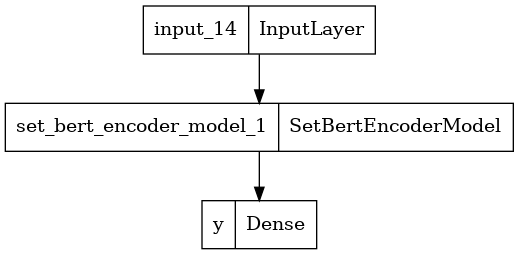

In [67]:
tf.keras.utils.plot_model(setbert_encoder, to_file="/tmp/model.png")

In [77]:
setbert_encoder.layers[1].layers

In [68]:
setbert_encoder.layers

In [54]:
# trained_predictions = setbert_encoder(train_dataset[0][0], return_attention_scores=True)
# untrained_predictions = setbert_encoder_pretrained(train_dataset[0][0], return_attention_scores=True)

trained_predictions = setbert_encoder(val_dataset[0][0], return_attention_scores=True)
untrained_predictions = setbert_encoder_pretrained(val_dataset[0][0], return_attention_scores=True)

In [61]:
len(trained_predictions[1][0])

8

In [ ]:
print("Is present:", val_dataset.get(batch_index)[3][index])

Is present: 1.0


In [133]:
tdata[sorted_indices[:20]]

array([96.21557 , 66.90698 , 62.063248, 57.093185, 57.093185, 51.6347  ,
       45.66148 , 38.548935, 32.55419 , 29.89124 , 28.528635, 28.41715 ,
       27.910433, 27.454433, 25.66349 , 25.112377, 24.25325 , 23.784433,
       23.292881, 22.95972 ], dtype=float32)

In [55]:
positive_samples = {}
negative_samples = {}
for s in samples:
    if targets[s.name] > 0.0:
        positive_samples[s.name] = s
    else:
        negative_samples[s.name] = s
len(positive_samples), len(negative_samples)

(190, 547)

In [71]:
# sequence_embeddings = {}
# for i, s in enumerate(samples):
#     print(f"\r{i+1}/{len(samples)}", end="")
#     g = SampleTargetGenerator([s], {s.name: 1}, sequence_length=250, kmer=3, subsample_size=1000, batch_size=10, batches_per_epoch=1)
#     _, fasta_ids, sequences, _ = g.get(0)
#     embeddings = setbert_encoder.base.dnabert_encoder.encode(sequences, chunk_size=256)
#     sequence_embeddings[s.name] = {
#         "fasta_ids": fasta_ids,
#         "sequences": embeddings
#     }
# with open("./alex_sequence_embeddings.pkl", 'wb') as f:
#     pickle.dump(sequence_embeddings, f)

In [73]:
with open("./logs/alex_sequence_embeddings.pkl", 'rb') as f:
    sequence_embeddings = pickle.load(f)

In [90]:
x = model.layers[2].input
y = model.layers[2].output
predictor = tf.keras.Model(x, y)

In [95]:
predictions = defaultdict(list)
infected_tax_scores = [defaultdict(int) for _ in range(8)] # scores for each transformer block
uninfected_tax_scores = [defaultdict(int) for _ in range(8)]
for i, (name, batch) in enumerate(sequence_embeddings.items()):
    print(f"\r{i+1}/{len(sequence_embeddings)}", end="")
    predictions[name].append(predictor(setbert_encoder(batch["sequences"], compute_sequence_embeddings=False)))
    pretrained = np.array(setbert_encoder_pretrained(batch["sequences"], compute_sequence_embeddings=False, return_attention_scores=True)[1][0]).astype(np.float64)
    finetuned = np.array(setbert_encoder(batch["sequences"], compute_sequence_embeddings=False, return_attention_scores=True)[1][0]).astype(np.float64)
    scores = finetuned[:,:,:,1:,1:] - pretrained[:,:,:,1:,1:] # remove class token
    # aggregate heads
    scores = np.sum(scores, axis=2)
    tax_score_blocks = infected_tax_scores if name in positive_samples else uninfected_tax_scores
    for tax_scores, block in zip(tax_score_blocks, scores):
        for asvs, batch_scores in zip(batch["fasta_ids"], block):
            batch_scores = batch_scores.sum(0)
            for index in np.argsort(batch_scores):
                tax_scores[tax_dict[asv_to_otu[asvs[index]]]] += batch_scores[index] / len(block)
with open("./logs/alex_attention_scores.pkl", 'wb') as f:
    pickle.dump((infected_tax_scores, uninfected_tax_scores), f)

737/737

In [54]:
with open("./logs/alex_attention_scores.pkl", 'rb') as f:
    (infected_tax_scores, uninfected_tax_scores) = pickle.load(f)

In [111]:
y_pred = np.array([*predictions.values()]).flatten()
y_pred.shape

(7370,)

In [128]:
y_true = np.repeat([int(name in positive_samples) for name in predictions.keys()], 10)
y_true.shape

(7370,)

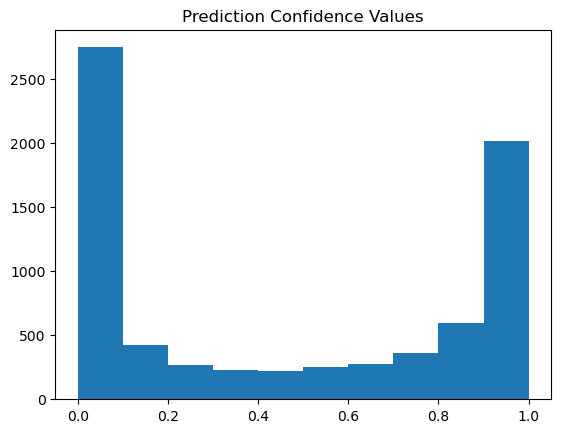

In [177]:
plt.title("Prediction Confidence Values")
plt.hist(y_pred)
plt.show()

Text(0.5, 1.0, 'Precision-Recall Curve')

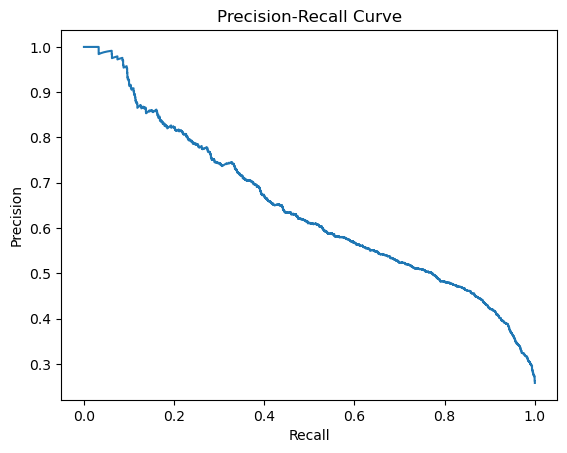

In [179]:
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")

Text(0, 0.5, 'Precision')

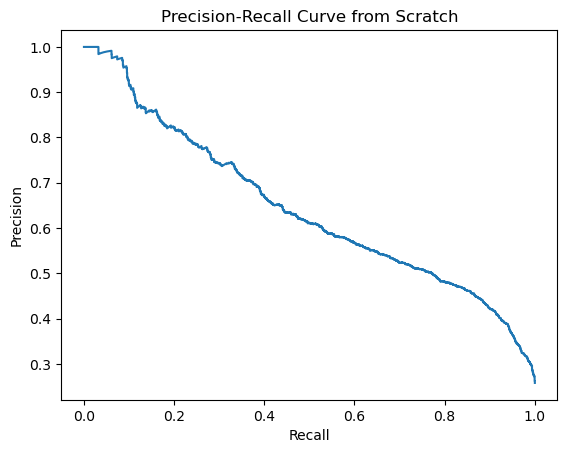

In [224]:
plt.title("Precision-Recall Curve from Scratch")
plt.plot(recall_points, precision_points)
plt.xlabel("Recall")
plt.ylabel("Precision")

In [190]:
indices = np.argsort(y_pred)
y_pred_sorted = y_pred[indices]
y_true_sorted = y_true[indices]

In [209]:
thresholds = np.concatenate((y_pred_sorted,))
thresholds.shape

(7370,)

In [226]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix

In [216]:
precision_points = []
recall_points = []
for threshold in thresholds:
    precision_points.append(precision_score(y_true, y_pred > threshold))
    recall_points.append(recall_score(y_true, y_pred > threshold))
precision_points = np.array(precision_points)
recall_points = np.array(recall_points)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
ppv_points = []
npv_points = []
for threshold in thresholds:
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred > threshold).ravel()
    ppv_points.append(tp / (tp + fp))
    npv_points.append(tn / (tn + fn))
ppv_points, npv_points = np.array(ppv_points), np.array(npv_points)

In [ ]:
indices = np.argsort(npv_points)
ppv_points = ppv_points[indices]
npv_points = npv_points[indices]

ppv_points[0] = 1.0
ppv_points = np.concatenate(([1.0], ppv_points))
npv_points = np.concatenate(([0.0], npv_points))

In [ ]:
plt.title("PPV/NPV Curve")
plt.plot(npv_points, ppv_points)
plt.ylabel("PPV")
plt.xlabel("NPV")

Text(0.5, 1.0, 'ROC Curve')

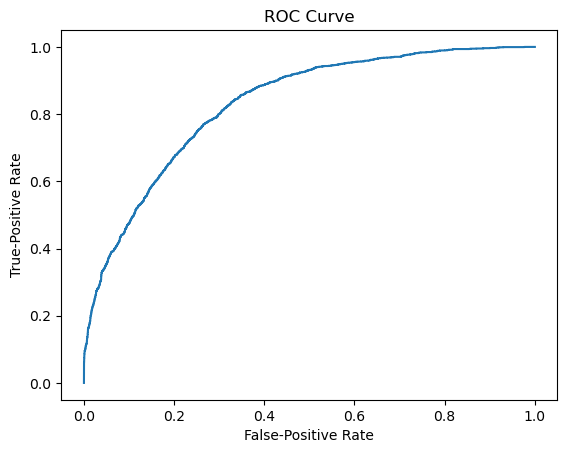

In [137]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr, tpr)
plt.xlabel("False-Positive Rate")
plt.ylabel("True-Positive Rate")
plt.title("ROC Curve")

In [184]:
precision, recall, fbeta, support = precision_recall_fscore_support(y_true, (y_pred > 0.95).astype(np.int64))
precision, recall, fbeta, support

(array([0.83350323, 0.61994609]),
 array([0.89689214, 0.48421053]),
 array([0.86403663, 0.54373522]),
 array([5470, 1900]))

In [ ]:
y_true

In [188]:
y_pred

array([0.00497107, 0.00790841, 0.00243119, ..., 0.00404325, 0.00574546,
       0.00544884], dtype=float32)

In [96]:
with open("./logs/alex_attention_scores.pkl", 'rb') as f:
    infected_tax_scores, uninfected_tax_scores = pickle.load(f)

---

## Taxonomy Ranks from Infected Samples

In [79]:
infected_tax_scores_aggregated = defaultdict(int)
for i in range(len(infected_tax_scores)):
    for tax, score in infected_tax_scores[i].items():
        infected_tax_scores_aggregated[tax] += score

### Highest Scoring Taxonomies

In [80]:
for i in range(len(infected_tax_scores)):
    print(f"Block {i+1}:")
    for tax, score in sorted(infected_tax_scores[i].items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {score:<20}", tax)

Block 1:
  9380.485502533995    k__Bacteria; p__Deinococcus-Thermus; c__Deinococci; o__Deinococcales; f__Deinococcaceae; g__Deinococcus
  6789.6182448495165   k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Betaproteobacteriales; f__Burkholderiaceae; g__Burkholderiaceae_unclassified
  3410.239918012774    k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhizobiales; f__Beijerinckiaceae; g__Methylobacterium
  2724.895521548744    k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Xanthomonadales; f__Xanthomonadaceae; g__Stenotrophomonas
  2707.7641504128906   k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhodobacterales; f__Rhodobacteraceae; g__Paracoccus
  1993.8034880777782   k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Sphingomonadales; f__Sphingomonadaceae; g__Sphingomonas
  906.6444384372224    k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Pseudomonadales; f__Moraxellaceae; g__Acinetobacter
  567.9016428694805    

### Lowest Scoring Taxonomies

In [82]:
for i in range(len(infected_tax_scores)):
    print(f"Block {i+1}:")
    for tax, score in sorted(infected_tax_scores[i].items(), key=lambda x: x[1], reverse=False)[:10]:
        print(f"  {score:<20}", tax)

Block 1:
  -4016.3258050888926  k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Propionibacteriales; f__Nocardioidaceae; g__Nocardioides
  -3174.3304423143077  k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Micrococcales; f__Intrasporangiaceae; g__Janibacter
  -2309.47717826624    k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Propionibacteriales; f__Nocardioidaceae; g__Marmoricola
  -1598.0123728585922  k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Micrococcales; f__Micrococcales_unclassified; g__Micrococcales_unclassified
  -1380.2592747848503  k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Micrococcales; f__Intrasporangiaceae; g__Intrasporangiaceae_unclassified
  -1234.9983936058868  k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Corynebacteriales; f__Mycobacteriaceae; g__Mycobacterium
  -1172.2736554139647  k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Micrococcales; f__Microbacteriaceae; g__Microbacteriaceae_unclassified
  -1026.01

In [138]:
for tax, score in sorted(infected_tax_scores_aggregated.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{score:<20}", tax)

25421.730572158984   k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Corynebacteriales; f__Dietziaceae; g__Dietzia
25347.969827241883   k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Flavobacteriales; f__Weeksellaceae; g__Chryseobacterium
22800.38477185191    k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Sphingomonadales; f__Sphingomonadaceae; g__Sphingomonas
18490.40404027229    k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhodobacterales; f__Rhodobacteraceae; g__Paracoccus
17479.145546763088   k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Micrococcales; f__Intrasporangiaceae; g__Janibacter
17460.214500515136   k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Xanthomonadales; f__Xanthomonadaceae; g__Stenotrophomonas
15251.424026017303   k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Betaproteobacteriales; f__Burkholderiaceae; g__Burkholderiaceae_unclassified
10961.486051807444   k__Bacteria; p__Actinobacteria; c__Actino

In [139]:
for tax, score in sorted(infected_tax_scores_aggregated.items(), key=lambda x: x[1])[:10]:
    print(f"{score:<20}", tax)

-7073.248995484208   k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Micrococcales; f__Dermacoccaceae; g__Flexivirga
-6149.033731295562   k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae; g__Enterobacteriaceae_unclassified
-4966.24539246448    k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Cytophagales; f__Microscillaceae; g__Siphonobacter
-3917.868951035235   k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Pseudomonadales; f__Moraxellaceae; g__Acinetobacter
-3338.9356892235255  k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__Enterococcaceae; g__Enterococcus
-2195.5691362798407  k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Micrococcales; f__Dermabacteraceae; g__Brachybacterium
-2130.1658887135154  k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Pseudomonadales; f__Pseudomonadaceae; g__Pseudomonas
-1824.7077783311634  k__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Bacilla

---

## Taxonomy Ranks from Uninfected Samples

In [140]:
uninfected_tax_scores_aggregated = defaultdict(int)
for i in range(len(uninfected_tax_scores)):
    for tax, score in uninfected_tax_scores[i].items():
        uninfected_tax_scores_aggregated[tax] += score

### Highest Scoring Taxonomies

In [141]:
for i in range(len(uninfected_tax_scores)):
    print(f"Block {i+1}:")
    for tax, score in sorted(uninfected_tax_scores[i].items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {score:<20}", tax)

Block 1:
  16675.28749017758    k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhizobiales; f__Beijerinckiaceae; g__Methylobacterium
  15579.60332364283    k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Betaproteobacteriales; f__Burkholderiaceae; g__Burkholderiaceae_unclassified
  12899.543138138959   k__Bacteria; p__Deinococcus-Thermus; c__Deinococci; o__Deinococcales; f__Deinococcaceae; g__Deinococcus
  8724.90535315106     k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Sphingomonadales; f__Sphingomonadaceae; g__Sphingomonas
  8523.17967572985     k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Xanthomonadales; f__Xanthomonadaceae; g__Stenotrophomonas
  5152.115021033601    k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhodobacterales; f__Rhodobacteraceae; g__Paracoccus
  3763.2138630217987   k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Pseudomonadales; f__Pseudomonadaceae; g__Pseudomonas
  3514.2616448674926  

### Lowest Scoring Taxonomies

In [142]:
for i in range(len(uninfected_tax_scores)):
    print(f"Block {i+1}:")
    for tax, score in sorted(uninfected_tax_scores[i].items(), key=lambda x: x[1], reverse=False)[:10]:
        print(f"  {score:<20}", tax)

Block 1:
  -11180.662124483093  k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Propionibacteriales; f__Nocardioidaceae; g__Nocardioides
  -6576.060910280052   k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Propionibacteriales; f__Nocardioidaceae; g__Marmoricola
  -6267.492902041994   k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Micrococcales; f__Intrasporangiaceae; g__Janibacter
  -6001.861031187719   k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Micrococcales; f__Microbacteriaceae; g__Microbacteriaceae_unclassified
  -5016.2413357845135  k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Micrococcales; f__Micrococcales_unclassified; g__Micrococcales_unclassified
  -4500.801699731155   k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Propionibacteriales; f__Nocardioidaceae; g__Aeromicrobium
  -3732.5436041484522  k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Corynebacteriales; f__Mycobacteriaceae; g__Mycobacterium
  -3463.2580831765354  k_

### Top Taxonomies

In [143]:
for tax, score in sorted(uninfected_tax_scores_aggregated.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{score:<20}", tax)

70823.93433163984    k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Betaproteobacteriales; f__Burkholderiaceae; g__Burkholderiaceae_unclassified
69345.48313297608    k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Sphingomonadales; f__Sphingomonadaceae; g__Sphingomonas
51781.4793739579     k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Corynebacteriales; f__Dietziaceae; g__Dietzia
46239.36570856147    k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Corynebacteriales; f__Mycobacteriaceae; g__Mycobacterium
41376.72902501707    k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Xanthomonadales; f__Xanthomonadaceae; g__Stenotrophomonas
32720.840502956828   k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Propionibacteriales; f__Nocardioidaceae; g__Nocardioides
31112.61233645914    k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhodobacterales; f__Rhodobacteraceae; g__Paracoccus
28973.65386836531    k__Bacteria; p__Actinobacteria;

In [144]:
for tax, score in sorted(uninfected_tax_scores_aggregated.items(), key=lambda x: x[1])[:10]:
    print(f"{score:<20}", tax)

-21403.425309543898  k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Pseudomonadales; f__Pseudomonadaceae; g__Pseudomonas
-12435.105294213376  k__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Staphylococcaceae; g__Staphylococcus
-9408.524057170556   k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Pseudomonadales; f__Moraxellaceae; g__Acinetobacter
-8931.18829552823    k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__Enterococcaceae; g__Enterococcus
-7033.072494585141   k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Micrococcales; f__Dermacoccaceae; g__Flexivirga
-6451.29598414839    k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Sphingomonadales; f__Sphingomonadaceae; g__Novosphingobium
-5854.8128475351505  k__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Bacillales_unclassified; g__Bacillales_unclassified
-4986.636946670838   k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterob

## Attention Attribution

In [48]:
from numba import njit
import settransformer as st

from deepdna.nn.data_generators import SequenceGenerator

In [49]:
attrs = None

In [113]:
def find_mha_layers(model):
    result = []
    for layer in model.layers:
        if isinstance(layer, st.SetAttentionBlock):
            result.append(layer.att)
        elif isinstance(layer, st.InducedSetAttentionBlock):
            result.append(layer.mab2.att)
        elif isinstance(layer, st.InducedSetEncoder):
            result.append(layer.mab.att)
        elif isinstance(layer, tf.keras.Model):
            result += find_mha_layers(layer)
    return result

@njit
def compute_token_attributions(attrs_by_layer):
    """
    Compute the attribution scores by token.
    """
    num_tokens = attrs_by_layer.shape[-1]
    attr_all = np.zeros(num_tokens)
    for i in range(num_tokens):
        for l in range(attrs_by_layer.shape[0]):
            for j in range(num_tokens):
                if j == i:
                    continue
                attr_all[i] += attrs_by_layer[l,i,j]
    return attr_all

def compute_attention_attribution_factory(call):

    if hasattr(call, "__iter__"):
        # Shift attention
        call_a, call_b = call
        @tf.function
        def compute_attention_attribution(x, mha_layers, integration_steps=20):
            # Initialize attention attribution weights
            for (layer_a, layer_b) in mha_layers:
                layer_a.enable_attribution()
                layer_b.enable_attribution()
                layer_a._alpha.assign([1.0]*layer_a.num_heads)
                layer_b._alpha.assign([1.0]*layer_b.num_heads)
            # Get the gradient shapes using a single call
            shapes = []
            _, scores = call_a(x)
            for layer_scores in scores: # [batch_index, head_index, n, n]
                batch_size = tf.shape(layer_scores)[0]
                n = tf.shape(layer_scores)[2]
                shapes.append((batch_size, n, n))
            # Compute attribution scores
            attrs = []
            for layer_index, (layer_a, layer_b) in enumerate(mha_layers):
                attrs.append([])
                for head in range(layer_a.num_heads):
                    grad_sum_a = tf.zeros(shapes[layer_index])
                    grad_sum_b = tf.zeros(shapes[layer_index])
                    for alpha in tf.linspace(0.0, 1.0, integration_steps):
                        layer_a.set_head_attribution_weight(head, alpha)
                        layer_b.set_head_attribution_weight(head, alpha)
                        with tf.GradientTape() as tape_a:
                            y_pred_a, scores_a = call_a(x)
                        with tf.GradientTape() as tape_b:
                            y_pred_b, scores_b = call_b(x)
                        grads_a = tape_a.gradient(y_pred_a, scores_a[layer_index])[:,head,:,:]
                        grads_b = tape_b.gradient(y_pred_b, scores_b[layer_index])[:,head,:,:]
                        grad_sum_a += grads_a
                        grad_sum_b += grads_b
                    attr_h_a = scores_a[layer_index][:,head,:,:]/integration_steps * grad_sum_a
                    attr_h_b = scores_b[layer_index][:,head,:,:]/integration_steps * grad_sum_b
                    attrs[-1].append(attr_h_b - attr_h_a)
            attrs = tf.transpose(attrs, (2, 0, 1, 3, 4))
            # attrs.shape == [sample_index, layer_index, head_index, n, n]
            return attrs

    else:
        @tf.function
        def compute_attention_attribution(x, mha_layers, integration_steps=20):
            # Initialize attention attribution weights
            for layer in mha_layers:
                layer.enable_attribution()
                layer._alpha.assign([1.0]*layer.num_heads)
            # Get the gradient shapes using a single call
            shapes = []
            _, scores = call(x)
            for layer_scores in scores: # [batch_index, head_index, n, n]
                batch_size = tf.shape(layer_scores)[0]
                n = tf.shape(layer_scores)[2]
                shapes.append((batch_size, n, n))
            # Compute attribution scores
            attrs = []
            for layer_index, layer in enumerate(mha_layers):
                attrs.append([])
                for head in range(layer.num_heads):
                    grad_sum = tf.zeros(shapes[layer_index])
                    for alpha in tf.linspace(0.0, 1.0, integration_steps):
                        layer.set_head_attribution_weight(head, alpha)
                        with tf.GradientTape() as tape:
                            y_pred, scores = call(x)
                        grads = tape.gradient(y_pred, scores[layer_index])[:,head,:,:]
                        grad_sum += grads
                    attr_h = scores[layer_index][:,head,:,:]/integration_steps * grad_sum
                    attrs[-1].append(attr_h)
            attrs = tf.transpose(attrs, (2, 0, 1, 3, 4))
            # attrs.shape == [sample_index, layer_index, head_index, n, n]
            return attrs

    return compute_attention_attribution

def merged_attention_attribution(data_generator, call, mha_layers, integration_steps=20, tau=0.4):
    global attrs

    mha_layers = tuple(mha_layers)

    # Create the compute_attention_attribution function to gather attribution scores for each layer/head
    if not hasattr(merged_attention_attribution, "call") or id(merged_attention_attribution.call) != id(call):
        print("Compiling execution graph... This may take several minutes.")
        merged_attention_attribution.call = call
        merged_attention_attribution.compute_attention_attribution = compute_attention_attribution_factory(call)
    compute_attention_attribution = merged_attention_attribution.compute_attention_attribution

    token_ids = {}
    token_total_attrs = defaultdict(float)
    top_node = None
    top_node_value = -np.inf

    taus = [tau]*(len(mha_layers) - 1) + [0.0]
    edges_by_layer = [set() for _ in range(len(taus))]

    n = 0
    for (token_names, x) in data_generator:
        print(f"\rComputing attention attribution: Step {n+1}", end="")
        # Ensure token names have a corresponding ID
        for token_name in token_names:
            if token_name not in token_ids:
                token_ids[token_name] = len(token_ids)
        attrs = compute_attention_attribution(tf.expand_dims(x, axis=0), mha_layers)[0]
        attrs_by_layer = np.sum(attrs, axis=1)[:,1:,1:] # strip off class tokens
        token_attrs = compute_token_attributions(attrs_by_layer)

        # Sum up total attribution for each token
        for i, value in enumerate(token_attrs):
            token_total_attrs[token_ids[token_names[i]]] += value

        # Update the top node
        max_value = np.max(token_attrs)
        if max_value > top_node_value:
            top_node = token_ids[token_names[np.argmax(token_attrs)]]
            top_node_value = max_value

        # Create tree adges
        for l, (tau, edges) in enumerate(zip(taus, edges_by_layer)):
            a_ij = attrs_by_layer[l]
            max_attr_l = np.max(attrs_by_layer[l])
            for (i, j) in np.argwhere(a_ij/max_attr_l > tau):
                i_universal = token_ids[token_names[i]]
                j_universal = token_ids[token_names[j]]
                edges.add((i_universal, j_universal))

        n += 1

    assert top_node is not None

    NotAppear, Appear, Fixed = "NotAppear", "Appear", "Fixed"
    state = {id: NotAppear for id in token_ids.values()}
    state[top_node] = Appear
    edges = set()
    vertices = set([top_node])
    for l in range(len(taus) - 2, -1, -1):
        for (i, j) in edges_by_layer[l]:
            if i == j:
                continue
            if state[i] is Appear and state[j] is NotAppear:
                edges.add((i, j))
                vertices.add(j)
                state[i] = Fixed
                state[j] = Appear
            if state[i] is Fixed and state[j] is NotAppear:
                edges.add((i, j))
                vertices.add(j)
                state[j] = Appear

    # Inject class token identifier
    vertices.add(-1)
    for j in range(len(state) - 1, -1, -1):
        if state[j] in (Appear, Fixed):
            edges.add((-1, j))

    # Compute the reversed ID map
    token_id_reverse_map = {v: k for k, v in token_ids.items()}
    token_id_reverse_map[-1] = "[CLS]"

    return {
        "token_id_map": token_id_reverse_map,
        "token_attrs": token_total_attrs,
        "edges": edges,
        "vertices": vertices
    }

In [102]:
def build_tree(vertices, edges, node_labels):
    # Create the tree graphic
    tree = Digraph()
    for vertex in vertices:
        label = node_labels[vertex]
        if label != "[CLS]":
            label = taxonomy.split_taxonomy(tax_dict[asv_to_otu[label]])[5]
        tree.node(label)
    for (i, j) in edges:
        i = node_labels[i]
        j = taxonomy.split_taxonomy(tax_dict[asv_to_otu[node_labels[j]]])[5]
        if i != "[CLS]":
            i = taxonomy.split_taxonomy(tax_dict[asv_to_otu[i]])[5]
        tree.edge(j, i)
    tree.graph_attr["rankdir"] = "BT"
    return tree

In [103]:
setbert_encoder.layers

In [104]:
y = x = tf.keras.layers.Input((1000, 128))
y, scores = setbert_encoder_pretrained(y, return_attention_scores=True, compute_sequence_embeddings=False)
y = tf.keras.layers.Dense(1, activation="sigmoid")(y)
setbert_encoder_pretrained_2 = tf.keras.Model(x, (y, scores))

In [75]:
y = x = tf.keras.layers.Input((1000, 128))
y, scores = setbert_encoder.layers[1](y, return_attention_scores=True, compute_sequence_embeddings=False)
y = setbert_encoder.layers[2](y)
setbert_encoder_finetuned = tf.keras.Model(x, (y, scores))

In [70]:
t_positive_samples = {name: positive_samples[name] for i, name in enumerate(positive_samples) if i < 1}
len(t_positive_samples)

1

In [108]:
def call_a(x):
    y_pred, scores = setbert_encoder_pretrained_2(x, training=False)
    return y_pred, scores[0][0]

def call_b(x):
    y_pred, scores = setbert_encoder_finetuned(x, training=False)
    return y_pred, scores[0][0]

def subsample_generator(samples, num_subsamples, subsample_size):
    for name, s in samples.items():
        gen = SequenceGenerator(
            [s],
            sequence_length=250,
            kmer=3,
            batch_size=1,
            batches_per_epoch=num_subsamples,
            subsample_size=subsample_size)
        for i in range(num_subsamples):
            _, sequence_ids, x, _ = gen.get(i)
            x = tf.stop_gradient(setbert_encoder.layers[1].base.dnabert_encoder.encode(x))
            yield sequence_ids[0], x[0]

## Attention Attribution Result

In [199]:
data_generator = subsample_generator(t_positive_samples, 10, 1000)
mha_layers = find_mha_layers(setbert_encoder.layers[1].model)
result = merged_attention_attribution(data_generator, call_a, mha_layers)

Compiling execution graph... This may take several minutes.
Computing attention attribution: Step 1

/tmp/ipykernel_2219074/3173404409.py:105: RuntimeWarning: invalid value encountered in true_divide
  for (i, j) in np.argwhere(a_ij/max_attr_l > tau):


Computing attention attribution: Step 10

Burkholderiaceae_unclassified
Pseudomonas
Chryseobacterium
Fimbriiglobus
[CLS]


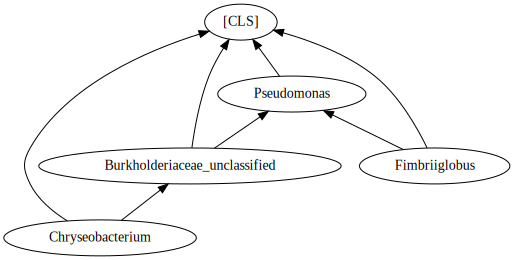

In [207]:
build_tree(result["vertices"], result["edges"], result["token_id_map"])

In [202]:
result["vertices"]

{-1, 487, 1414, 1475, 1913}

In [ ]:
data_generator = subsample_generator(positive_samples, 10, 1000)
mha_layers = find_mha_layers(setbert_encoder.layers[1].model)
result2 = merged_attention_attribution(data_generator, call, mha_layers)

Compiling execution graph... This may take several minutes.
Computing attention attribution: Step 1

/tmp/ipykernel_4411/833680966.py:153: RuntimeWarning: invalid value encountered in true_divide
  for (i, j) in np.argwhere(a_ij/max_attr_l > tau):


Computing attention attribution: Step 824

In [ ]:
build_tree(result2["vertices"], result2["edges"], result2["token_id_map"])

## Attention Attribution Shift

In [114]:
data_generator = subsample_generator(t_positive_samples, 10, 1000)

mha_layers_pretrained = find_mha_layers(setbert_encoder_pretrained_2.layers[1].model)
mha_layers_finetuned = find_mha_layers(setbert_encoder_finetuned.layers[1].model)
assert len(mha_layers_pretrained) == len(mha_layers_finetuned)

result = merged_attention_attribution(data_generator, (call_a, call_b), zip(mha_layers_pretrained, mha_layers_finetuned))

Compiling execution graph... This may take several minutes.
Computing attention attribution: Step 1


KeyboardInterrupt



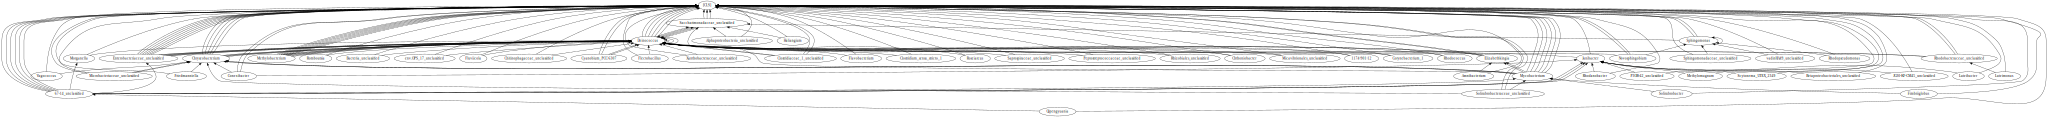

In [111]:
build_tree(result["vertices"], result["edges"], result["token_id_map"])